# PyTorch
[CIFAR 10 Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## 1. Data Preprocessing



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

datadir = '/content/gdrive/MyDrive/HAM10000'
import os 
os.path.exists(datadir)

metadata_path = os.path.join(datadir,"HAM10000_metadata.csv")
print(metadata_path)

Mounted at /content/gdrive
/content/gdrive/MyDrive/HAM10000/HAM10000_metadata.csv


In [ ]:
import pandas as pd
metadata = pd.read_csv(metadata_path)
print(metadata)
print(metadata.dx.value_counts())

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc

In [ ]:
from sklearn.model_selection import train_test_split

def split_data():
  metadata = pd.read_csv(metadata_path)
  lesion_column = metadata['lesion_id']
  unique_lesions = lesion_column.unique()
  print(len(unique_lesions))
  test_size = 0.2
  trainval_lesions,test_lesions = train_test_split(unique_lesions,test_size = test_size,random_state = 1000)
  train_lesions,val_lesions = train_test_split(trainval_lesions,test_size = test_size,random_state = 1000)
  train = metadata[metadata['lesion_id'].isin(train_lesions)]
  val = metadata[metadata['lesion_id'].isin(val_lesions)]
  test = metadata[metadata['lesion_id'].isin(test_lesions)]
  train.to_csv(os.path.join(datadir,"train.csv"),index=False)
  val.to_csv(os.path.join(datadir,"val.csv"),index=False)
  test.to_csv(os.path.join(datadir,"test.csv"),index=False)
split_data()

7470


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
IMAGE_SIZE = 224
train_transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
     transforms.RandomHorizontalFlip(p = 0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(degrees=45),
     
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

test_transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
# [0, 1] -> [-0.5, 0.5] -> [-1, 1]

In [ ]:
from PIL import Image

class Dataset(torch.utils.data.Dataset):

    def __init__(self,split,transforms):
      self.split = split
      self.transforms = transforms
      self.df = pd.read_csv(os.path.join(datadir,f"{split}.csv"))
      self.classes = ['nv','mel','bkl','others']

    def __len__(self):
      return len(self.df)
      
    def __getitem__(self, index):
      row = self.df.iloc[index]
      image_path = os.path.join(datadir,'images',f"{row.image_id}.jpg")
      image = Image.open(image_path)
      X = self.transforms(image)
      if row.dx in self.classes:
        y = self.classes.index(row.dx)
      else:
        y = 3
      return (X,y)

train_dataset = Dataset('train',train_transform)
val_dataset = Dataset('val',test_transform)
test_dataset = Dataset('test',test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32,
                                          shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                          shuffle=False, num_workers=4)

In [ ]:
for dataset in [train_dataset,test_dataset,val_dataset]:
  print(dataset.df[['lesion_id','age']].groupby('lesion_id').mean()['age'].std())
  print(dataset.df[['lesion_id','age']].groupby('lesion_id').mean()['age'].mean())
  print(dataset.df.shape)
  print(dataset.df['lesion_id'].unique().shape)
  dataset.df['binarysex']=dataset.df['sex'].apply(lambda sex:sex=='female')
  print (dataset.df[['lesion_id','binarysex']].groupby('lesion_id').mean()['binarysex'].mean())
  

16.051465649716
51.84265881363063
(6444, 7)
(4780,)
0.452510460251046
16.360333868805235
50.90479405806887
(2000, 7)
(1494,)
0.46987951807228917
15.414879772715496
51.86390532544379
(1571, 7)
(1196,)
0.46321070234113715


In [ ]:
train_dataset.df.dx.value_counts()/train_dataset.df.shape[0]

nv       0.670391
mel      0.113594
bkl      0.106921
bcc      0.053073
akiec    0.031657
vasc     0.012570
df       0.011794
Name: dx, dtype: float64

### Let's show some of the training images, for fun

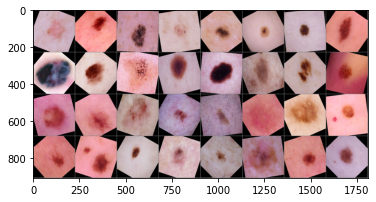

others    nv    nv others


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    """Display an image"""
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

In [ ]:
# Since our current network is small, gains from running on GPU will be small
# Let's load in a larger model
from torchvision import models
import torch
import torch.nn as nn

num_classes = len(train_dataset.classes)
net = models.densenet121(pretrained=True)

if 'fc' in net.__dict__['_modules']:
    num_ftrs = net.fc.in_features # (N, 1000)
    net.fc = nn.Linear(num_ftrs, num_classes) # (N, 1000) -> (N, 4)
elif 'classifier'in net.__dict__['_modules']:
    num_ftrs = net.classifier.in_features
    net.classifier = nn.Linear(num_ftrs, num_classes)
else:
    raise ValueError()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

# Recursively convert all parameters to CUDA tensors
net.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## 3. Define a Loss function and optimizer

In [ ]:
import torch.optim as optim
import torch.nn as nn

count = train_dataset.df.dx.value_counts()/train_dataset.df.shape[0]
print(count.index)

#weights = []

#for c in train_dataset.classes:
  #if c != 'others':
    #weights.append(1/count.loc[c])

#weights.append(sum(1/count.loc[c] for c in ['bcc', 'akiec', 'vasc', 'df']))
#print(weights)

criterion = nn.CrossEntropyLoss(weight=torch.cuda.FloatTensor(weights))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Index(['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], dtype='object')


## 4. Train the network

In [ ]:
exp_name = 'withoutpretraining'
exp_dir = os.path.join(datadir,'experiments',exp_name)
os.makedirs(exp_dir, exist_ok=True)
save_path = os.path.join(exp_dir,'model.pth')

In [ ]:
best_accuracy = 0
tolerance = 1
save_path = os.path.join(exp_dir,'model.pth')
print(f"running with save_path {save_path}")

for epoch in range(10):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # Have to move data to the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
      for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
       
    current_accuracy = ((correct/total)*100)

    print('Accuracy of the network on the validation images: %f %%' % (current_accuracy))

    if current_accuracy > best_accuracy:
      best_accuracy = current_accuracy
      tolerance = 1
      print('saving network')

      torch.save(net.state_dict(), save_path)

    elif tolerance >= 3:
      break

    else:
      tolerance += 1
      
print('Finished Training')

running with save_path /content/gdrive/MyDrive/HAM10000/experiments/withoutpretraining/model.pth
Accuracy of the network on the validation images: 68.555060 %
saving network
Accuracy of the network on the validation images: 71.292171 %
saving network
Accuracy of the network on the validation images: 71.992362 %
saving network
Accuracy of the network on the validation images: 75.366009 %
saving network
Accuracy of the network on the validation images: 73.965627 %
Accuracy of the network on the validation images: 76.511776 %
saving network
Accuracy of the network on the validation images: 72.437938 %
Accuracy of the network on the validation images: 74.220242 %
Accuracy of the network on the validation images: 76.702737 %
saving network
Finished Training


## 5. Test the network on the validation data
### Let's display images from the validation set

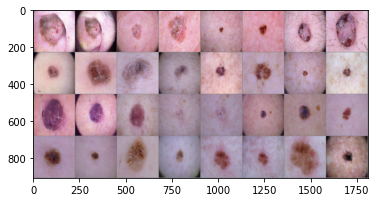

GroundTruth:    bkl   bkl   bkl   bkl


In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % val_dataset.classes[labels[j]] for j in range(4)))

Accuracy of the network on the validation images: 76 %


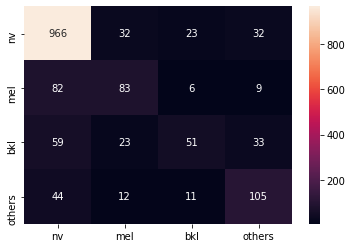

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics

correct = 0
total = 0
predictedlist = []
labelslist = []

net.load_state_dict(torch.load(save_path))

with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        labelslist.extend(labels.cpu().numpy().tolist())
        _, predicted = torch.max(outputs.data, 1)
        predictedlist.extend(predicted.cpu().numpy().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

y_true = labelslist
y_pred = predictedlist
target_names = train_dataset.classes
with open(os.path.join(exp_dir, 'results.txt'), 'w') as f:
    print(classification_report(y_true,y_pred,target_names=target_names),file=f)

from sklearn.metrics import confusion_matrix
y_true = [target_names[i] for i in y_true]
y_pred = [target_names[i] for i in y_pred]
c_matrix = confusion_matrix(y_true, y_pred, labels=target_names)

fmt = "d"
ax=sns.heatmap(c_matrix,annot=True,fmt=fmt,xticklabels=target_names,yticklabels=target_names)
plt.savefig(os.path.join(exp_dir, 'val_matrix.png'))

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics

correct = 0
total = 0
predictedlist = []
labelslist = []

net.load_state_dict(torch.load(save_path))

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        labelslist.extend(labels.cpu().numpy().tolist())
        _, predicted = torch.max(outputs.data, 1)
        predictedlist.extend(predicted.cpu().numpy().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

y_true = labelslist
y_pred = predictedlist
target_names = train_dataset.classes
with open(os.path.join(exp_dir, 'test_results.txt'), 'w') as f:
    print(classification_report(y_true,y_pred,target_names=target_names),file=f)

#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_true, y_pred, labels=target_names)

Accuracy of the network on the test images: 75 %
